# Teste Data Science Elo7

Esse teste faz parte da segunda etapa do processo seletivo para a vaga no time Data Science do Elo7. O objetivo do teste é avaliar como você desenvolve uma solução completa (em nível de prova de conceito) para um problema de sistemas de recomendação, que é uma das tarefas que mais realizamos no nosso dia-a-dia.



# Dataset:

O conjunto de dados foi gerado em 17 de outubro de 2016 e descreve a classificação de 5 estrelas e a atividade de tags textuais da base pública do Movie Lens, um serviço de recomendação de filmes. Os dados estão contidos em seis arquivos, genome-scores.csv, genome-tags.csv, links.csv, movies.csv, ratings.csv e tags.csv. 


Estes dados contém 20.000.263 classificações e 465.564 tags em 27.278 filmes. Foram criados por 138.493 usuários entre 09 de janeiro de 1995 e 31 de março de 2015, no qual cada um deles foi selecionados aleatoriamente para inclusão. Cada funcionário selecionado pode avaliar pelo menos 20 filmes.

#### Formatação e Codificação

O conjunto de dados é separado por [comma-separated values] com apenas uma única linha de cabeçalho. Além disso, cabe destacar que esses arquivos são codificados como UTF-8

#### Ids dos Usuários

Os ids dos usuários são anônimos e consistentes entre os arquivos `ratings.csv` e `tags.csv`.

####  Ids dos Filmes

Foram incluídos nessa base de dados os filmes com pelo menos uma classificação ou tag. Os ids dos filmes são concistentes entre as bases `ratings.csv`, `tags.csv`, `movies.csv`, e `links.csv`.

####  Estrutura de arquivos de dados de classificações (ratings.csv)

Todas as classificações estão contidas no arquivo `ratings.csv`. Cada linha desse arquivo após a linha de cabeçalho representa uma avaliação de um filme por um usuário e tem o seguinte formato: `userId, movieId, classificação, timestamp`. As linhas nesse arquivo são ordenadas primeiro por `userId` e, em seguida, por `user`, e, por fim, por `movieId`. As classificações são feitas em uma escala de 5 estrelas, com incrementos de meia estrela (0,5 estrelas - 5,0 estrelas).

####  Estrutura de arquivos de dados de filmes (movies.csv)

A informação do filme está contida no arquivo `movies.csv`. Cada linha desse arquivo após a linha de cabeçalho representa um filme e tem o seguinte formato: `movieId, título, gêneros`. Os títulos de filmes são inseridos manualmente ou importados de <https://www.themoviedb.org/> e incluem o ano de lançamento entre parênteses. 


####  Estrutura de arquivos de dados de links (links.csv)

Identificadores que podem ser usados para ligar a outras fontes de dados de filmes estão contidos no arquivo `links.csv`. Cada linha desse arquivo após a linha de cabeçalho representa um filme e tem o seguinte formato: `movieId, imdbId, tmdbId`


####  Genoma Tag  (genome-scores.csv e genome-tags.csv)

Este conjunto de dados inclui uma cópia atual do Genoma de tags, estrutura de dados que contém pontuações de relevância de tags para filmes, de maneira a codificar a intensidade com que os filmes exibem propriedades específicas representadas por tags (atmosféricas, instigantes, realistas etc.). 

O genoma do tag foi calculado usando um algoritmo de aprendizado de máquina em conteúdo contribuído pelo usuário, incluindo tags, classificações e resenhas textuais e dividido em dois arquivos. O primeiro: `genome-scores.csv` contém dados de relevância da tag de filme no seguinte formato: `movieId, tagId, relevância`. Já o segundo arquivo: `genome-tags.csv`, fornece as descrições de tag para os IDs de tag no seguinte formato:`tagId, tag`. 

Os valores `tagId` são gerados quando o conjunto de dados é exportado, portanto eles podem variar de versão para versão dos conjuntos de dados MovieLens.

De maneira a analisar os dados deveremos agrupar as colunas dos diversos arquivos seguinto os agrupamentos do esquema abaixo:
Primeiro agrupamos os arquivos: genome-scores.csv com o geno-tag.csv pelo `tagId`. Segundo agrupamos os arquivos, genome-scores.csv, movies.csv, links.csv e ratings.csv pelo `movieId`.




## Carregamento dos dados

In [1]:
#Bibliotecas
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import dateutil
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

In [4]:
# path = '/Users/sabrinaalvarez/Desktop/Projects/ml-20m'
path = 'C:\Users\samara.alves\Desktop\ml-20m\ml-20m'

In [5]:
movies = pd.read_csv(path + '/movies.csv', sep=',',  encoding="utf-8")

In [6]:
ratings = pd.read_csv(path + '/ratings.csv', sep=',',  encoding="utf-8", usecols=range(3))

## Análise conjunto de dados

In [7]:
display(movies.head())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
display(ratings.head())

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


### Limpeza dados ausentes

In [9]:
print ("Numero de linhas na tabela movies com valores nulos:", max(movies.isnull().sum()))
print ("Numero de linhas na tabela ratings com valores nulos:", max(ratings.isnull().sum()))
movies.dropna(inplace=True)
ratings.dropna(inplace=True)

('Numero de linhas na tabela movies com valores nulos:', 0L)
('Numero de linhas na tabela ratings com valores nulos:', 0L)


### Ajuste dos Data Frames

#### Separar em colunas distintas o título e o ano

In [10]:
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year 
movies.title = movies.title.str[:-7]
display(movies.head())

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,2,Jumanji,Adventure|Children|Fantasy,1995.0
2,3,Grumpier Old Men,Comedy|Romance,1995.0
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0
4,5,Father of the Bride Part II,Comedy,1995.0


### Agrupamento dos arquivos 

In [11]:
#Agrupamento arquivos movies e ratings
movie_rating = pd.merge(movies, ratings)
print(movie_rating.shape)

(20000263, 6)


#### Tabela quantidade e média votos por movieId

In [12]:
def tabel_agg(df):
    aggregations = {'rating':['count','mean']}
    new_df = df.groupby(['movieId', 'title', 'genres', 'year']).agg(aggregations)
    columns = new_df.columns.tolist()
    new_df.columns = ['n.votes','rating']
    return new_df

In [13]:
tabel_agg_movieId = tabel_agg(movie_rating)
tabel_agg_movieId.reset_index(inplace=True)  
display(tabel_agg_movieId.head())

,movieId,title,genres,year,n.votes,rating
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,49695,3.921240
1,2,Jumanji,Adventure|Children|Fantasy,1995.0,22243,3.211977
2,3,Grumpier Old Men,Comedy|Romance,1995.0,12735,3.151040
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0,2756,2.861393
4,5,Father of the Bride Part II,Comedy,1995.0,12161,3.064592


#### Tabela quantidade e média votos por ano de produção do filme

In [14]:
def tabel_agg_year(df):
    aggregations = {'rating':['count','mean']}
    new_df = df.groupby(['year']).agg(aggregations)
    columns = new_df.columns.tolist()
    new_df.columns = ['n.votes','rating']
    return new_df

In [15]:
tabel_agg_year = tabel_agg_year(movie_rating)
tabel_agg_year.reset_index(inplace=True)
display(tabel_agg_year.head(10))

,year,n.votes,rating
0,1891.0,1,3.000000
1,1893.0,4,3.375000
2,1894.0,14,3.071429
3,1895.0,3,2.833333
4,1896.0,23,3.282609
5,1898.0,14,3.785714
6,1899.0,4,3.625000
7,1900.0,6,3.166667
8,1901.0,1,5.000000
9,1902.0,254,3.738189


# Parte 1 - Análise Exploratória

**Questões**:

    1) Distribuição das classificações por filme e usuário
    
    2) Distribuição das classificações por ano
         
    3) Ditribuição dos gêneros dos filmes 


## Distribuição das classificações por filme e usuário

In [16]:
ratings_mean = movie_rating[['movieId','rating']].groupby('movieId').mean()
ratings_mean['n.votes'] = movie_rating[['movieId','rating']].groupby('movieId').count()

In [17]:
ratings_mean.describe()

,rating,n.votes
count,26744.000000,26744.000000
mean,3.133200,747.841123
std,0.664084,3085.818268
min,0.500000,1.000000
25%,2.800000,3.000000
50%,3.235294,18.000000
75%,3.565217,205.000000
max,5.000000,67310.000000


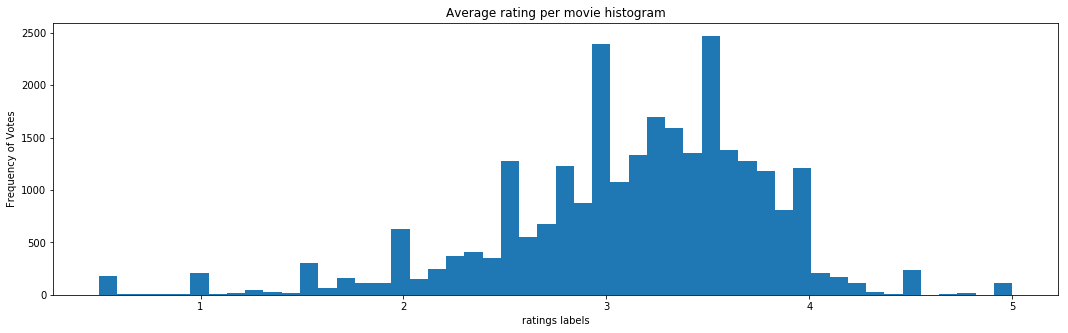

In [18]:
fig = plt.figure(figsize = (18,5))
plt.hist(ratings_mean['rating'], bins = 50)
plt.title("Average rating per movie histogram")
plt.xlabel("ratings labels")
plt.ylabel("Frequency of Votes")

fig.show()

A distribuição da média dos votos por filme apresenta uma distribuição assimétrica à esquerda o que nos indica que essas notas estão concentradas em notas mais altas e acima da mediana dos votos (3.235294). Isso pode ser explicado porque os filmes mais bem classificados são os mais recomedados ao público o que aumenta a sua média de classificação. Na figura abaixo, podemos observar ainda melhor essa relação observando a correlação entre número de votos e classificação do filme

C:\ProgramData\Anaconda2\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


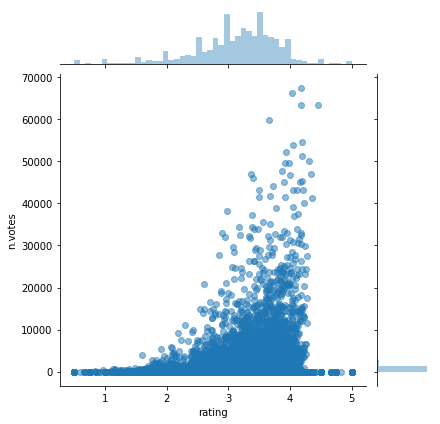

In [19]:
sns.jointplot(x ='rating', y ='n.votes', data = tabel_agg_movieId, alpha = 0.5)

In [20]:
ratings_mean_user = movie_rating[['userId','rating']].groupby('userId').mean()
ratings_mean_user['n.votes'] = movie_rating[['userId','rating']].groupby('userId').count()

In [21]:
ratings_mean_user.describe()

,rating,n.votes
count,138493.000000,138493.000000
mean,3.627209,144.413530
std,0.443030,230.267257
min,0.500000,20.000000
25%,3.369478,35.000000
50%,3.653846,68.000000
75%,3.923077,155.000000
max,5.000000,9254.000000


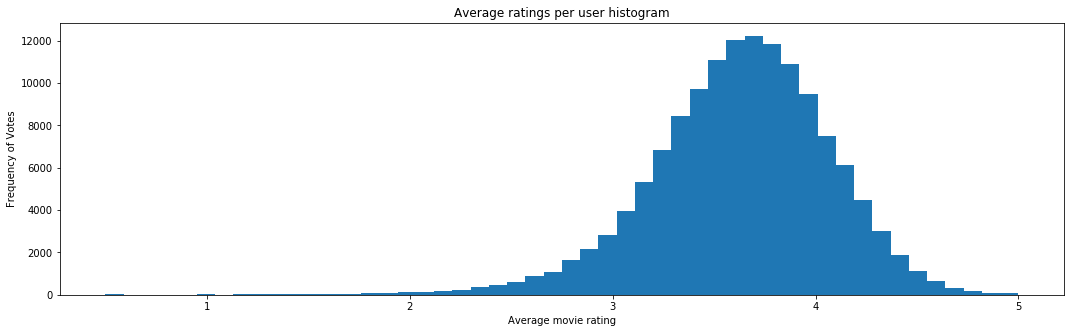

In [22]:
fig = plt.figure(figsize = (18,5))
plt.hist(ratings_mean_user['rating'], bins = 50)
plt.title("Average ratings per user histogram")
plt.xlabel("Average movie rating")
plt.ylabel("Frequency of Votes")

fig.show()

A distribuição da média dos votos por usuário apresenta uma distribuição assimétrica à esquerda assim como o gráfico anterior, contudo, a média e mediana dos votos são maiores que as observadas na tabela agrupada por filme. Enquanto que nos dados agrupados por filme a média e a mediana foram 3.133200 e 3.23529, respectivamente, a média e a mediana dos dados agrupados por usuário foram 3.627209 e 3.653846, respectivamente. Isso pode ter algumas explicações, dentre elas o fato de que o sistema de recoemdação tem uma alta taxa de acerto e indica filmes de interesse do usuário.

## Distribuição das classificações por ano

In [23]:
ratings_year = movie_rating[['year','rating']].groupby('year').mean()
display(ratings_year.head())

,rating
year,
1891.0,3.000000
1893.0,3.375000
1894.0,3.071429
1895.0,2.833333
1896.0,3.282609


In [24]:
def get_dic_year(tabel, labels):
    dic_year = {}
    dic_year['index'] = []
    dic_year['n.votes'] = []
    dic_year['rating'] = []
    for i in range(len(tabel)):
        if str(tabel['year'][i]) in labels:
            dic_year['index'].append(str(tabel.index[i]))
            dic_year['n.votes'].append(tabel.values[i][1])
            dic_year['rating'].append(tabel.values[i][2])

    df = pd.DataFrame(dic_year)    
    return df

In [25]:
#Selecionar apenas de 1980 a 2009
labels = ['1980.0','1981.0','1982.0','1983.0','1984.0','1985.0','1986.0','1987.0','1988.0','1989.0',
          '1990.0','1991.0','1992.0','1993.0','1994.0','1995.0','1996.0','1997.0','1998.0','1999.0',
          '2000.0','2001.0','2002.0','2003.0','2004.0','2005.0','2006.0','2007.0','2008.0','2009.0']

ratings_year_80 = get_dic_year(tabel_agg_year, labels)
display(ratings_year_80.head())

,index,n.votes,rating
0,82,216220.0,3.697121
1,83,197820.0,3.691715
2,84,250902.0,3.589252
3,85,195069.0,3.657665
4,86,335956.0,3.562401


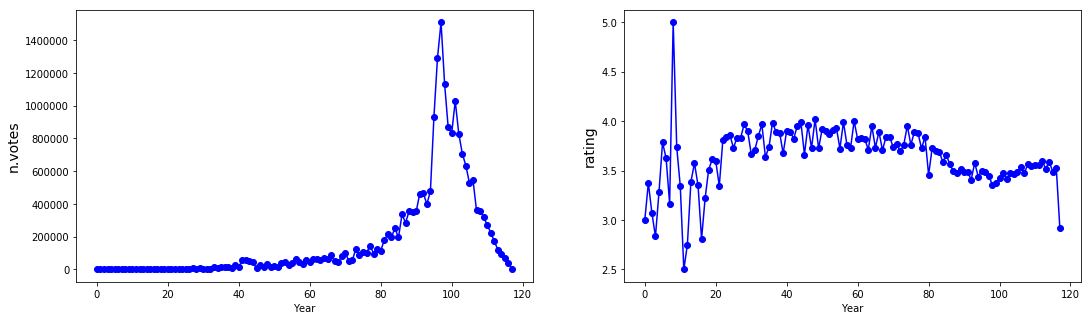

In [24]:
fig = plt.figure(figsize = (18,5))
for i, feature in enumerate(['n.votes', 'rating']):
    ax = fig.add_subplot(1, 2, i+1)
    ax.plot(tabel_agg_year[feature], "b-o")
    ax.set_ylabel("%s"%(feature), fontsize = 14)
    ax.set_xlabel('Year')
    
fig.show()

Como pode ser visto no gráfico acima, o maior volume de votos ocorreu entre os anos de 1980 e 2010. Sendo assim, de maneira a avaliar melhor a distribuição da média das classificações restringimos a base agrupada por ano para esse período.

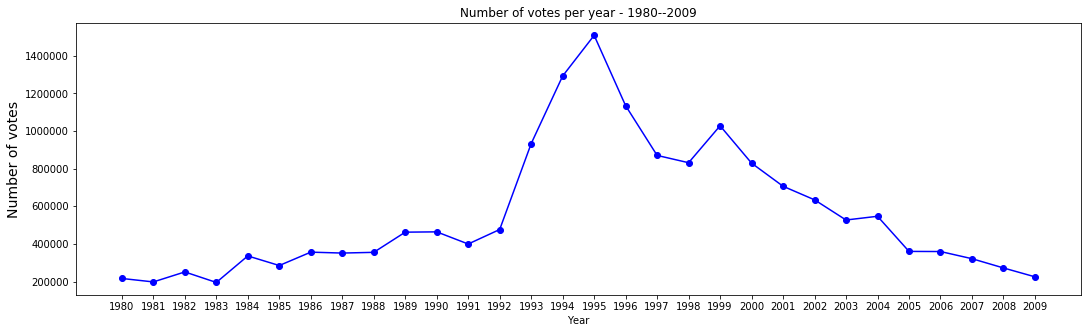

In [26]:
labels = ['1980','1981','1982','1983','1984','1985','1986','1987','1988','1989',
          '1990','1991','1992','1993','1994','1995','1996','1997','1998','1999',
          '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']

fig = plt.figure(figsize = (18,5))
for i, feature in enumerate([ 'n.votes']):
    ax = fig.add_subplot(1, 1, i+1)
    ax.plot(ratings_year_80[feature], "b-o")
    ax.set_ylabel("Number of votes", fontsize = 14)
    ax.set_xlabel('Year')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
plt.title('Number of votes per year - 1980--2009')
fig.show()

O maior volume de classificação dos filmes da base cresceu consideravelmente a partir de 1992, atingindo a maior contagem de votos entre 1994 e 1995. Observa-se uma queda dessa votação em 1996 e um outro pico (menor que o primeiro em 1999).

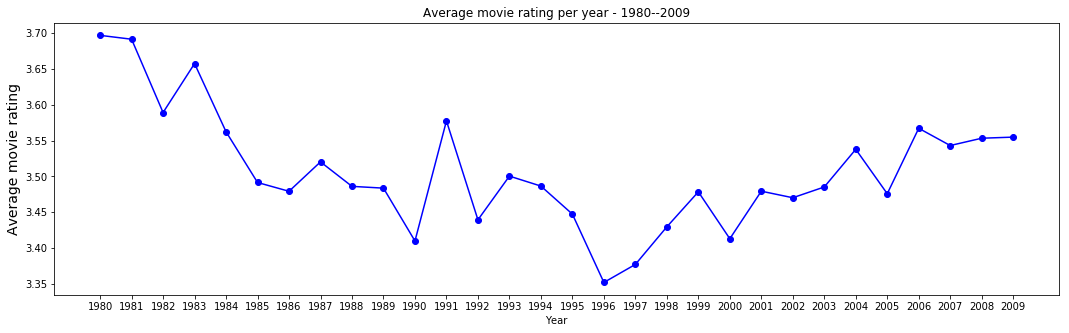

In [27]:
labels = ['1980','1981','1982','1983','1984','1985','1986','1987','1988','1989',
          '1990','1991','1992','1993','1994','1995','1996','1997','1998','1999',
          '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']

fig = plt.figure(figsize = (18,5))
for i, feature in enumerate([ 'rating']):
    ax = fig.add_subplot(1, 1, i+1)
    ax.plot(ratings_year_80[feature], "b-o")
    ax.set_ylabel("Average movie rating", fontsize = 14)
    ax.set_xlabel('Year')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
#     ax1.set_ylabel('Number of movies released'); ax2.set_ylabel('Number of ratings')

plt.title('Average movie rating per year - 1980--2009')
fig.show()

A distribuição da média dos votos, por sua vez, apresenta um comportamente distinto do comportamento da distirbuição do número de votos. Podemos observar que em 1980 a média das classificações foi 3.70, depois disso a média das notas passa a apresentar uma tendência de queda até 1990 onde ocorre um ciclo de novo crescimento. A menor pontuação ocorre em 1196 (média próxima de 3.35). Após esse maior vale observamos um novo ciclo de alta mais significativo até o final da base em 2009.

## Distribuição das classificações por gênero

In [28]:
display(tabel_agg_movieId.head())

,movieId,title,genres,year,n.votes,rating
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,49695,3.921240
1,2,Jumanji,Adventure|Children|Fantasy,1995.0,22243,3.211977
2,3,Grumpier Old Men,Comedy|Romance,1995.0,12735,3.151040
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0,2756,2.861393
4,5,Father of the Bride Part II,Comedy,1995.0,12161,3.064592


Os filmes da base foram classificados nos gêneros: 

In [29]:
def genres_dic_list(df, genres_unique):
    dic_gener = {}
    dic_gener['title'] = []
    dic_gener['count'] = []
    for genre in genres_unique: 
        count = 0       
        if genre == '(no genres listed)':
            pass
        else:       
            for index in range(len(df)): 
                if genre in df['genres'][index]:
                    count += 1  
            dic_gener['title'].append(genre)        
            dic_gener['count'].append(count)
    return dic_gener

A função anterior contabiliza o número de filmes por gêneros da lista:

In [30]:
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
print ('Lista dos generos dos filmes: {}').format(list(genres_unique))

Lista dos generos dos filmes: [u'Adventure', u'Animation', u'Children', u'Comedy', u'Fantasy', u'Romance', u'Drama', u'Action', u'Crime', u'Thriller', u'Horror', u'Mystery', u'Sci-Fi', u'IMAX', u'Documentary', u'War', u'Musical', u'Western', u'Film-Noir', u'(no genres listed)']


In [31]:
dic_gener = genres_dic_list(tabel_agg_movieId, genres_unique)
number_genres = pd.DataFrame(dic_gener)

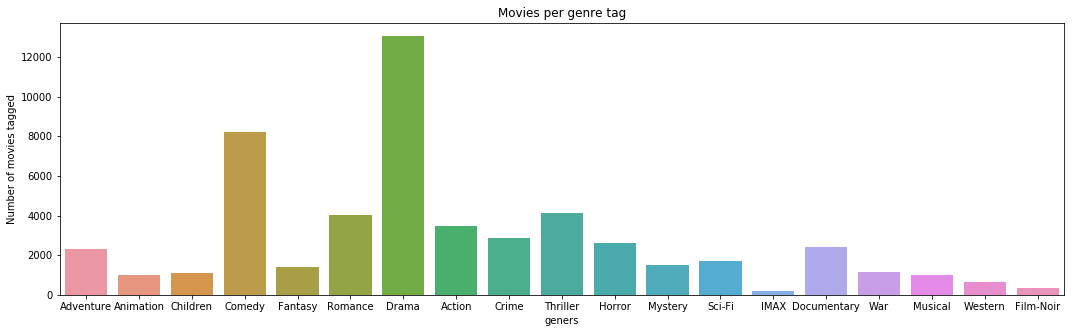

In [32]:
fig = plt.figure(figsize = (18,5))
sns.barplot(data = number_genres, x="title",y="count")
plt.title("Movies per genre tag")
plt.xlabel("geners")
plt.ylabel("Number of movies tagged")

fig.show()

Como vimos nas tabelas anteriores um mesmo filme pode receber mais de uma tag de gênero. Para analisar os gêneros com as maiores frequências de tags, apresentamos o gráfico acima. Nele é possível perceber que o gênero `Drama` é a tag mais utilizada na classificação dos gêneros dos filmes em 13.058 vezes, seguido de `Comedy`, em 8.227 vezes, `Thriller`, em 4.128 vezes, `Romance`, em 4.029 vezes, e `Action` em 3.465 vezes. 

In [33]:
display(number_genres.sort_values(by=['count'], ascending=False).head(10))

,count,title
6,13058,Drama
3,8227,Comedy
9,4128,Thriller
5,4029,Romance
7,3465,Action
8,2888,Crime
10,2590,Horror
14,2387,Documentary
0,2287,Adventure
12,1718,Sci-Fi


Criaremos uma nova tabela para aprofundar a análise da influência dos gêneros dos filmes no ranking e no número de votos. para isso atribuiremos o valor `1` para os gêneros (descritos na lista acima) que são encontrados na descrição da lista de gêneros de cada filme e `0` caso contrário.

In [34]:
genres_unique = pd.DataFrame(tabel_agg_movieId.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) 
tabel_agg_geners = tabel_agg_movieId.join(tabel_agg_movieId.genres.str.get_dummies())
tabel_agg_geners.drop('genres', inplace=True, axis=1)

In [35]:
col_list= list(tabel_agg_geners)
col_list.remove('movieId')
col_list.remove('year')
col_list.remove('title')
col_list.remove('n.votes')
col_list.remove('rating')
col_list.remove('(no genres listed)')
col_list

tabel_agg_geners['total'] = tabel_agg_geners[col_list].sum(axis=1)
display(tabel_agg_geners)

,movieId,title,year,n.votes,rating,(no genres listed),Action,Adventure,Animation,Children,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,total
0,1,Toy Story,1995.0,49695,3.921240,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,5
1,2,Jumanji,1995.0,22243,3.211977,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,3
2,3,Grumpier Old Men,1995.0,12735,3.151040,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2
3,4,Waiting to Exhale,1995.0,2756,2.861393,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,3
4,5,Father of the Bride Part II,1995.0,12161,3.064592,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,6,Heat,1995.0,23899,3.834930,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,3
6,7,Sabrina,1995.0,12961,3.366484,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2
7,8,Tom and Huck,1995.0,1415,3.142049,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,2
8,9,Sudden Death,1995.0,3960,3.004924,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,10,GoldenEye,1995.0,29005,3.430029,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,3


In [36]:
n_tags = tabel_agg_geners['total'].value_counts()

In [37]:
n_tags = pd.DataFrame( tabel_agg_geners['total'].value_counts())
n_tags.reset_index(inplace=True)

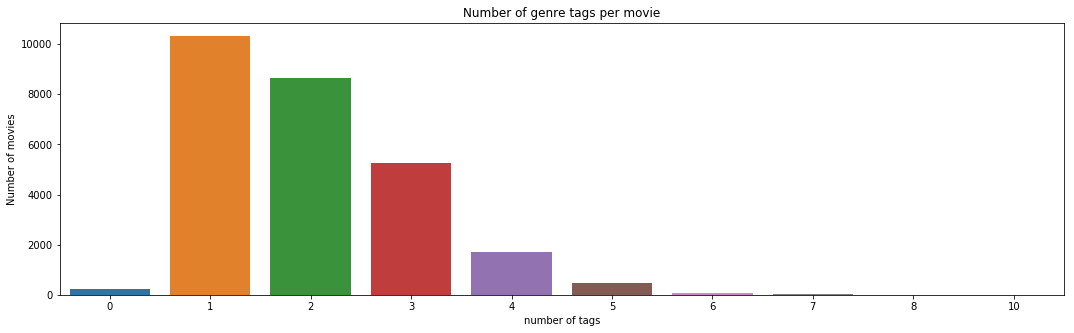

In [38]:
fig = plt.figure(figsize = (18,5))
sns.barplot(data = n_tags, x="index",y="total")
plt.title("Number of genre tags per movie")
plt.xlabel("number of tags")
plt.ylabel("Number of movies")

fig.show()

Na figura acima a relação entre o número de tags de gêneros por filme pode ser analisada. Na base a maioria dos filmes são classificados com apenas um gênero, são 10.583 filmes com essa descrição. Esse valor decresce com o aumento do número de gêneros, por exemplo, os filmes com 2 gêneros somam  8.809, com 3 gêneros somam 5.330, com 4 gêneros somam 1.724. Além disso, podemos destacar que apenas um filme possui na base um classificação com 10 gêneros diferentes.

In [39]:
def tabel_agg_total(df):
    aggregations = {'rating':['mean'],
                   'n.votes':['sum']}
    new_df = df.groupby(['total']).agg(aggregations)
    columns = new_df.columns.tolist()
    new_df.columns = ['rating','n.votes']
    return new_df

In [40]:
tabel_agg_geners_total = tabel_agg_total(tabel_agg_geners)
tabel_agg_geners_total.reset_index(inplace=True)
display(tabel_agg_geners_total)

,total,rating,n.votes
0,0,2.771531,349
1,1,3.170174,3377356
2,2,3.110066,5981143
3,3,3.102091,6318980
4,4,3.146114,3060965
5,5,3.179476,983969
6,6,3.188495,224303
7,7,3.326908,52477
8,8,3.441507,162
9,10,2.987013,154


In [41]:
tabel_agg_geners_total.describe()

,total,rating,n.votes
count,10.000000,10.000000,1.000000e+01
mean,4.600000,3.142338,1.999986e+06
std,3.204164,0.180170,2.527657e+06
min,0.000000,2.771531,1.540000e+02
25%,2.250000,3.104085,1.338100e+04
50%,4.500000,3.158144,6.041360e+05
75%,6.750000,3.186240,3.298258e+06
max,10.000000,3.441507,6.318980e+06


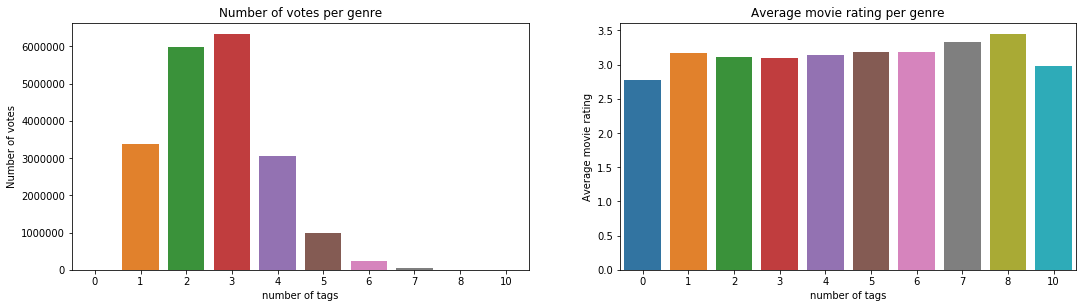

In [42]:
fig = plt.figure(figsize = (18,10))
plt.subplot(221)
sns.barplot(data = tabel_agg_geners_total, x="total",y="n.votes")
plt.title("Number of votes per genre")
plt.ylabel("Number of votes")
plt.xlabel("number of tags")

plt.subplot(222)
sns.barplot(data = tabel_agg_geners_total, x="total",y="rating")
plt.title("Average movie rating per genre")
plt.ylabel("Average movie rating")
plt.xlabel("number of tags")
plt.show()


Na figura à esquerda conseguimos visualizar que os filmes com 3 gêneros é o mais popular da base (maior número de votos) somando um total de 6.318.980, seguido dos filmes com 2 gêneros, que somam um total de 5.981.143, dos filmes com apenas 1 gênero com 3.377.356 votos, dos filmes com 4 gêneros com 3.060.965 votos e dos filmes com 5 gêneros com 983.969. 

Já na figura à direita temos a relação das médias de pontuação dos filmes pela quantidade de gêneros que eles possuem. Podemos ver que os filmes com 8 gêneros que somam 162 votos têm a maior média de pontuação 3.441507. A segunda melhor média de pontuação 3.326908 é dos filmes com 7 gêneros que somam um total de 52477 votos. Essas pontuações estão avaliadas acima do percentil 75% e podem significar conjuntos muito específicos de filmes que são bem recebidos pelo seu público alvo.  

As demais pontuações dos filmes com  2, 3 e 4 gêneros se concentram entre os percentils 25% e 50%, com valores , 3.110066, 3.102091 e 3.146114, respectivamente. Os filmes com apenas um gênero são muito bem classificados com média 3.170174, contudo, essa pontuação é esperada uma vez que a quantidade de filmes com essa descrição na base é maior. 

Podemos verificar portanto, que filmes com 2 e 3 gêneros provavelmente serão os filmes com as melhores colocações nos rankings do sistema de recomendação, uma vez que são muito votados e que apresenta um média de votos alta.



### Relação entre os gêneros dos filmes

In [113]:
def tabel_agg_genre(df, genre):
    aggregations = {
                'Drama':['sum'],
                'Comedy':['sum'],
                'Thriller':['sum'],
                'Romance':['sum'],
                'Action':['sum'],
                'Crime':['sum'],
                'Horror':['sum'],
                'Documentary':['sum'],
                'Adventure':['sum'],
                'Sci-Fi':['sum'],
                 'Animation':['sum'],
                 'Children':['sum'],
                 'Fantasy':['sum'],
                 'Mystery':['sum'],
                 'IMAX':['sum'],
                 'War':['sum'],
                 'Musical':['sum'],
                 'Western':['sum'],
                 'Film-Noir':['sum'],}

    
    new_df = df.groupby([genre]).agg(aggregations)
    columns = new_df.columns.tolist()
    new_df.columns = ['Mystery', 'Romance', 'Western', 'Sci-Fi', 'Horror', 'Film-Noir', 'Crime', 'Drama', 'Fantasy', 'Musical',
                     'Animation', 'War',  'Adventure', 'Action', 'Comedy', 'Documentary','Children', 'Thriller', 'IMAX']
    return new_df

In [102]:
def tabel_agg_row(tabel, genre):
    new_df = tabel_agg_genre(tabel, genre)
    new_df.index.names = ['Genre'] 
    new_df.drop(new_df.index[[0]], inplace=True)
    new_df.rename(index={1:genre}, inplace=True)
    
    return new_df

In [118]:
# Tabela relação entre os gêneros dos filmes
column_list =['Mystery', 'Romance', 'Western', 'Sci-Fi', 'Horror', 'Film-Noir', 'Crime', 'Drama', 'Fantasy', 'Musical',
                     'Animation', 'War',  'Adventure', 'Action', 'Comedy', 'Documentary','Children', 'Thriller', 'IMAX']

genre = []
for i in range(len(column_list)):
    genre.append(column_list[i])
    
print (genre)    

['Mystery', 'Romance', 'Western', 'Sci-Fi', 'Horror', 'Film-Noir', 'Crime', 'Drama', 'Fantasy', 'Musical', 'Animation', 'War', 'Adventure', 'Action', 'Comedy', 'Documentary', 'Children', 'Thriller', 'IMAX']


In [119]:
tabel_1 = tabel_agg_row(tabel_agg_geners, genre[0])
tabel_2 = tabel_agg_row(tabel_agg_geners, genre[1])
tabel_1 = tabel_1.append(tabel_2)
tabel_3 = tabel_agg_row(tabel_agg_geners, genre[2])
tabel_1 = tabel_1.append(tabel_3)
tabel_4 = tabel_agg_row(tabel_agg_geners, genre[3])
tabel_1 = tabel_1.append(tabel_4)
tabel_5 = tabel_agg_row(tabel_agg_geners, genre[4])
tabel_1 = tabel_1.append(tabel_5)
tabel_6 = tabel_agg_row(tabel_agg_geners, genre[5])
tabel_1 = tabel_1.append(tabel_6)
tabel_7 = tabel_agg_row(tabel_agg_geners, genre[6])
tabel_1 = tabel_1.append(tabel_7)
tabel_8 = tabel_agg_row(tabel_agg_geners, genre[7])
tabel_1 = tabel_1.append(tabel_8)
tabel_9 = tabel_agg_row(tabel_agg_geners, genre[8])
tabel_1 = tabel_1.append(tabel_9)
tabel_10 = tabel_agg_row(tabel_agg_geners, genre[9])
tabel_1 = tabel_1.append(tabel_10)
tabel_11 = tabel_agg_row(tabel_agg_geners, genre[10])
tabel_1 = tabel_1.append(tabel_11)
tabel_12 = tabel_agg_row(tabel_agg_geners, genre[11])
tabel_1 = tabel_1.append(tabel_12)
tabel_13 = tabel_agg_row(tabel_agg_geners, genre[12])
tabel_1 = tabel_1.append(tabel_13)
tabel_14 = tabel_agg_row(tabel_agg_geners, genre[13])
tabel_1 = tabel_1.append(tabel_14)
tabel_15 = tabel_agg_row(tabel_agg_geners, genre[14])
tabel_1 = tabel_1.append(tabel_15)
tabel_16 = tabel_agg_row(tabel_agg_geners, genre[15])
tabel_1 = tabel_1.append(tabel_16)
tabel_17 = tabel_agg_row(tabel_agg_geners, genre[16])
tabel_1 = tabel_1.append(tabel_17)
tabel_18 = tabel_agg_row(tabel_agg_geners, genre[17])
tabel_1 = tabel_1.append(tabel_18)
tabel_19 = tabel_agg_row(tabel_agg_geners, genre[18])
tabel_1 = tabel_1.append(tabel_19)
# tabel_1['total'] = tabel_1[column_list].sum(axis=1)
display(tabel_1)

,Mystery,Romance,Western,Sci-Fi,Horror,Film-Noir,Crime,Drama,Fantasy,Musical,Animation,War,Adventure,Action,Comedy,Documentary,Children,Thriller,IMAX
Genre,,,,,,,,,,,,,,,,,,,
Mystery,1488,150,11,135,388,64,459,715,118,12,27,18,75,137,224,11,26,784,7
Romance,150,4029,109,97,72,33,237,2509,240,319,69,182,286,262,1854,13,69,258,10
Western,11,109,656,17,12,1,29,154,6,22,8,27,101,127,134,2,11,27,2
Sci-Fi,135,97,17,1718,448,8,51,347,187,24,155,31,379,632,313,11,77,455,63
Horror,388,72,12,448,2590,7,159,448,187,23,31,19,80,268,392,19,9,1065,13
Film-Noir,64,33,1,8,7,322,173,229,5,4,2,3,5,13,9,0,0,120,0
Crime,459,237,29,51,159,173,2888,1677,33,23,30,27,141,759,679,38,18,1214,11
Drama,715,2509,154,347,448,229,1677,13058,390,328,130,876,670,1176,2498,114,212,1841,39
Fantasy,118,240,6,187,187,5,33,390,1397,105,263,21,508,320,471,6,308,128,50


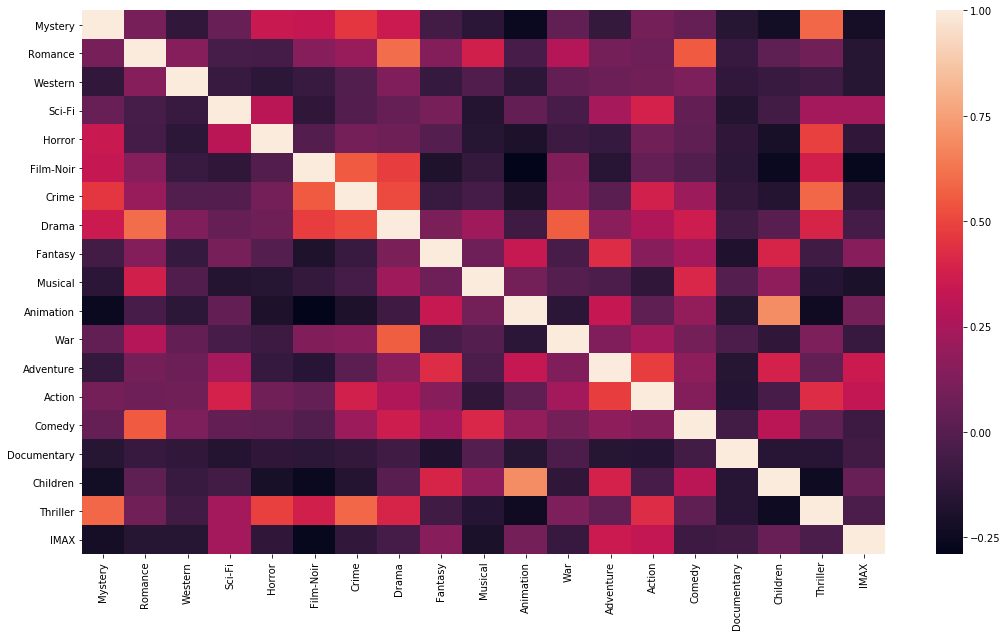

In [120]:
# Matriz de correlação
corr = tabel_1.corr()
fig = plt.figure(figsize = (18,10))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)


De maneira a avaliar a relação entre os gêneros dos filmes montamos uma tabela com a frequência com que os diferentes gêneros apareceram juntos no mesmo filme e depois transaformamos essa visualização calculando a correlação linear entre essas frequências. A visualização dessas correlações encontram-se representadas acima no heatmap. Destacamos que a escala de cor a direita do gráfico indica uma correlação positiva entre os gêneros nas cores mais claras e negativa nas cores mais escuras. Sendo assim, verificamos que os filmes com tag de gêneros `Mistery` geralmente são associadas as tags de `Crime`, `Horror`, `Drama` e ainda `Film-Noir`. Já os filmes com tag de gênero `Romance` são muito associados as tags de `Drama`, `Comedy`, `Musical` e `War`. Os filmes com tag de gênero `Children` são fortemente associados as tags `Animation`, `Fantasy` e `Adventure`.  

# Parte 2 - Sistema de Recomendação

O objetivo das técnicas de Sistemas de Recomendação é recomendar itens relevantes para usuários, com base em suas preferências. A preferência e a relevância são subjetivas e geralmente são inferidas por itens que os usuários consumiram anteriormente.

As principais técnicas são:

**Filtragem Colaborativa:** Este método faz previsões automáticas (filtragem) sobre os interesses de um usuário, coletando preferências ou utilizando informações de outros usuários. O pressuposto dessa abordagem é que, se uma pessoa A tiver a mesma opinião que uma pessoa B em um conjunto de itens, A terá maior probabilidade de ter a opinião de B para um determinado item do que a de uma pessoa escolhida aleatoriamente.

**Filtragem Baseada em Conteúdo:** Este método usa apenas informações sobre a descrição e os atributos dos itens que os usuários já consumiram para modelar as preferências do usuário. Em outras palavras, esses algoritmos tentam recomendar itens semelhantes aos que um usuário gostou no passado (ou está examinando no presente). Em particular, vários itens candidatos são comparados com itens previamente classificados pelo usuário e os itens de melhor correspondência são recomendados.

**Métodos híbridos:** Pesquisas recentes demonstraram que uma abordagem híbrida, combinando filtragem colaborativa e filtragem baseada em conteúdo, poderia ser mais eficaz do que abordagens puras em alguns casos. 

Referência: https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101

## Modelo de benchmark

Primeiro definiremos um sistema de recomendação simples que possa ser generalizado para todos os usuários, no qual exibiremos os filmes com as melhores classificações por gênero. Esse modelo não leva em consideração as preferências do usuário, ele apenas considera que filmes mais bem classificados (populares) serão melhores aceitos como recomendações.

Referência: https://www.quora.com/How-does-IMDbs-rating-system-work

Podemos observar pela tabela abaixo que a média geral dos ratings é 3.5255.

In [39]:
# Estatística Descritiva da base de dados 
movie_rating['rating'].describe()

count    2.000026e+07
mean     3.525529e+00
std      1.051989e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

O primeiro código de recomendação classificará os filmes apenas pela valor ponderado de W, fórmula de classificação ponderada do IMDB:

$$W = (\frac{v}{v+m})R + (\frac{m}{v+m})C$$

onde:  
   - R: classificação média do filme
   - C: classificação média geral 
   - v: quantidade de votos do filme
   - m: quantidade mínima de votos para entrar na lista de recomendação. 
   
Definimos ser o valor de m o percentil 95% das classificações.

In [40]:
def indice_W(df, quantile):
    W = []
    C = np.mean(df['rating'])
    m = df.quantile(quantile)[0]
    index_list = df.index.values
    for index in index_list:
        R = df['rating'][index]
        v = df['n.votes'][index]
        frac1 = v/(v + m)
        frac2 = m/(v + m)
        W.append(frac1 * R + frac2 * C)
    return W

In [41]:
quantile = 0.95
W = indice_W(tabel_agg_movieId, quantile)
tabel_agg_movieId['W'] = W
tabel1_top = tabel_agg_movieId.sort_values(by=['W'], ascending=False)

Abaixo podemos verificar a lista dos 10 filmes mais bem cassificados pelos usuários na base de dados. 

In [42]:
display(tabel1_top.head(10))

,movieId,title,genres,year,n.votes,rating,W
315,318,"Shawshank Redemption, The",Crime|Drama,1994.0,63366,4.446990,3.580809
293,296,Pulp Fiction,Comedy|Crime|Drama|Thriller,1994.0,67310,4.174231,3.502080
587,593,"Silence of the Lambs, The",Crime|Horror|Thriller,1991.0,63299,4.177057,3.488531
523,527,Schindler's List,Drama|War,1993.0,50054,4.310175,3.474295
49,50,"Usual Suspects, The",Crime|Mystery|Thriller,1995.0,47006,4.334372,3.465975
257,260,Star Wars: Episode IV - A New Hope,Action|Adventure|Sci-Fi,1977.0,54502,4.190672,3.458503
352,356,Forrest Gump,Comedy|Drama|Romance|War,1994.0,66172,4.029000,3.447088
2486,2571,"Matrix, The",Action|Sci-Fi|Thriller,1999.0,51334,4.187186,3.444130
843,858,"Godfather, The",Crime|Drama,1972.0,41355,4.364732,3.443687
1171,1196,Star Wars: Episode V - The Empire Strikes Back,Action|Adventure|Sci-Fi,1980.0,45313,4.188202,3.417743


Podemos melhorar o algoritmo e recomendar os melhores filmes da base por gênero. Para isso, criaremos tabelas com os filmes por gênero e só depois disso calcularemos a média ponderada W. 

Os filmes são classicados nas categorias: 
* Ação, Aventura, Animação, Crianças, Comédia, Crime, Documentário, Drama, Fantasia, Film-Noir, Horror, Musical, Mistério, Romance, Ficção científica, Suspense,  Guerra, Ocidental e (sem gêneros listados).

Contudo, cabe esclarecer que essas classificações são combinadas e ao todos podemos observar um total de 1.342 gêneros. Sendo assim, para criar as novas tabelas verificaremos se o gênero de interesse está incluído na classificação do filme.

In [43]:
def get_tabel_geners(list_genre, df, genre):
    frame = []
    for index in list_genre: 
        #selecionar apenas as linhas da tabela relacionadas ao genero de interesse
        row = (df['genres'] == index)
        new_df = df[row]
        frame.append(new_df)
    return frame

Abaixo temos uma tabela que aggrega os dados da tabela gerada `movie_rating` por gênero de interesse, quantidade e média de votos  


In [44]:
def genres_dic_list(df, genre):
    genres_dic = df['genres'].value_counts().to_dict()
    genres_dic.keys()
    list_genre = []
    for genre_index in genres_dic.keys():
        if genre in genre_index:
            list_genre.append(str(genre_index))
    return list_genre

In [45]:
genre = 'Musical'
list_genre = genres_dic_list(movies, genre)
print 'Total da lista de classificações dos filmes que incluem o gênero {}: {}'.format(genre, len(list_genre))

Total da lista de classificações dos filmes que incluem o gênero Musical: 175


In [46]:
frame = get_tabel_geners(list_genre, tabel_agg_movieId, genre)
tabel_agg_genres = pd.concat(frame)

Por fim, calculamos as médias das classificações ponderadas por W.

In [47]:
quantile = 0.95
W = indice_W(tabel_agg_genres, quantile)
tabel_agg_genres['W'] = W
tabel_genres_top = tabel_agg_genres.sort_values(by=['W'], ascending=False)

##### Top 10 filmes Musicais

In [48]:
display(tabel_genres_top.head(10))

,movieId,title,genres,year,n.votes,rating,W
360,364,"Lion King, The",Adventure|Animation|Children|Drama|Musical|IMAX,1994.0,38991,3.779090,3.334955
902,919,"Wizard of Oz, The",Adventure|Children|Fantasy|Musical,1939.0,23445,3.981681,3.319088
582,588,Aladdin,Adventure|Animation|Children|Comedy|Musical,1992.0,41842,3.680871,3.316515
589,595,Beauty and the Beast,Animation|Children|Fantasy|Musical|Romance|IMAX,1991.0,35138,3.673302,3.298152
1052,1073,Willy Wonka & the Chocolate Factory,Children|Comedy|Fantasy|Musical,1971.0,28335,3.709935,3.287390
1194,1220,"Blues Brothers, The",Action|Comedy|Musical,1980.0,19824,3.804782,3.274408
547,551,"Nightmare Before Christmas, The",Animation|Children|Fantasy|Musical,1993.0,20509,3.731849,3.265885
882,899,Singin' in the Rain,Comedy|Musical|Romance,1952.0,10219,4.080879,3.255867
1016,1035,"Sound of Music, The",Musical|Romance,1965.0,14049,3.804434,3.250140
1009,1028,Mary Poppins,Children|Comedy|Fantasy|Musical,1964.0,14096,3.732406,3.242317


Podemos ainda recomendar os melhores filmes com base no ano de produção. O cálculo desse ranking segue a mesma ideia da classificação por gênero de filme.


In [49]:
quantile = 0.95
W = indice_W(tabel_agg_year, quantile)
tabel_agg_year['W'] = W
tabel_agg_year_top = tabel_agg_year.sort_values(by=['W'], ascending=False)

##### Top 10 filmes por Ano de Produção

In [50]:
display(tabel_agg_year_top.head(10))

,year,n.votes,rating,W
48,1946.0,35770,4.019542,3.999250
59,1957.0,55155,4.000399,3.987661
56,1954.0,64891,3.990345,3.979763
44,1942.0,43349,3.993149,3.977417
74,1972.0,88152,3.953387,3.946359
43,1941.0,49986,3.955087,3.942834
64,1962.0,71501,3.950847,3.942296
36,1934.0,12560,3.985748,3.937790
46,1944.0,25096,3.960890,3.936955
33,1931.0,17155,3.967211,3.932695
